<a id="library">Python Libraries</a>

**[Data Preparation](#dataprep)**

**[HistGradientBoosting](#histboost)**

In this book we will CatBoost. As it is best Classifier. We are going ask the question
- What are women saying about their overall experience
- What are men saying about their overall experience.

Gather insights and fill Gender missing values


In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

import missingno as msno

from scipy.stats import chi2_contingency


from numpy import sqrt, argmax

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler

from sklearn import metrics
from sklearn.metrics import (
        confusion_matrix, classification_report,accuracy_score, precision_recall_curve,
        precision_score,recall_score,f1_score, roc_curve, roc_auc_score )

from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, \
    AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer
from sklearn.compose import ColumnTransformer

import scipy.stats as stats

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import FeatureUnion,make_pipeline,Pipeline

# Functions used in EDA. 
def histogram_boxplot(data, feature, figsize=(9, 3), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height() + 10       # height of the plot
        ax.annotate(percentage, (x, y), size = 10) # annotate the percentage 
        
    plt.show() # show the plot
    
# function to create labeled barplots


def labeled_barplot(data, feature, perc=True, n=None, xtick_rotation=0):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=xtick_rotation, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot
    
## Show metrics for Models after fit() and predict()
def metrics_score2(model_name, y_test, prediction, y_scores):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])

    auc = roc_auc_score(y_test,y_scores[:,1])
    
    print(f'{model_name} - AUC: {str(round(auc, 2))}\n')
    print(f"{model_name} Classification Report")
    print("-"*40)
    print(classification_report(y_test, prediction))
    
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    
    fig = plt.figure(figsize=(12,6))
    
    # plot ROC curve
    # Plot the diagonal 50% line
    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 5]}, figsize=(12,6))
    plt.subplots_adjust(
                    wspace=0.2)

    a0.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    a0.plot(fpr, tpr)
    a0.set_xlabel('False Positive Rate')
    a0.set_ylabel('True Positive Rate')
    a0.set_title('ROC Curve')
    
    a0.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
    
    ## Precision-Recall curve

 
    cm=confusion_matrix(y_test, prediction)
    labels = ['TN','FN','FP','TP']
    #categories = [ 'Repaid','Default']
    make_confusion_matrix(cm, 
                          group_names=labels,
                          #categories=categories, 
                          cmap='Blues', title=model_name+" - Acutals vs Predicted",
                          ax=a1)
    plt.show()

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          ax=None,
                          cmap='Blues',
                          title=None,
                          xlabel="Actual",
                          ylabel="Predicted"):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    if (ax == None):
        plt.figure(figsize=figsize)
        ax = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
        ax.set(xlabel=xlabel, ylabel=ylabel)
    else:
        sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,ax=ax)
        ax.set(xlabel=xlabel, ylabel=ylabel)

    
    if title:
        plt.title(title)

<a id="library">Python Libraries</a>
**[Current](#current)**
**[AdaBoost](#adaboost)**

In [3]:
travel_data_train = pd.read_csv("datasets/TravelData_train_.csv")
survey_data_train = pd.read_csv("datasets/Surveydata_train_.csv")

travel_data_test = pd.read_csv("datasets/TravelData_test_.csv")
survey_data_test = pd.read_csv("datasets/Surveydata_test_.csv")

In [7]:
#travel_data_train.head()
#travel_data_train.dtypes
#travel_data_train.info()
#travel_data_train.nunique()
travel_data_train.describe()

#survey_data_train.head()
#survey_data_train.dtypes
#survey_data_train.info()
#survey_data_train.nunique()
survey_data_train.describe()

#df.isnull().sum().sort_values(ascending=False) 

,ID,Overall_Experience
count,9.437900e+04,94379.000000
mean,9.884719e+07,0.546658
std,2.724501e+04,0.497821
min,9.880000e+07,0.000000
25%,9.882360e+07,0.000000
50%,9.884719e+07,1.000000
75%,9.887078e+07,1.000000
max,9.889438e+07,1.000000


#### Compare Train and Test Data for missing values

In [8]:
## Travel Data

null_count_travel_data_train = pd.DataFrame(data=[travel_data_train.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (travel_data_train.isna().sum()/travel_data_train.shape[0]*100).tolist()]], 
               columns=travel_data_train.columns, index=['Train NaN Count', 'Train NaN Percent']).transpose().sort_values(by='Train NaN Count', ascending=False)

null_count_travel_data_test = pd.DataFrame(data=[travel_data_test.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (travel_data_test.isna().sum()/travel_data_test.shape[0]*100).tolist()]], 
               columns=travel_data_test.columns, index=['Test NaN Count', 'Test NaN Percent']).transpose().sort_values(by='Test NaN Count', ascending=False)

side_by_side_travel = pd.concat([null_count_travel_data_train, null_count_travel_data_test], axis=1)

## Survey Data

null_count_survey_data_train = pd.DataFrame(data=[survey_data_train.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (survey_data_train.isna().sum()/survey_data_train.shape[0]*100).tolist()]], 
               columns=survey_data_train.columns, index=['Train NaN Count', 'Train NaN Percent']).transpose().sort_values(by='Train NaN Count', ascending=False)

null_count_survey_data_test = pd.DataFrame(data=[survey_data_test.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (survey_data_test.isna().sum()/survey_data_test.shape[0]*100).tolist()]], 
               columns=survey_data_test.columns, index=['Test NaN Count', 'Test NaN Percent']).transpose().sort_values(by='Test NaN Count', ascending=False)

side_by_side_survey = pd.concat([null_count_survey_data_train, null_count_survey_data_test], axis=1)

## Join the the two the HTML code and print 

html_str = "<h4>Travel data and Survey data: Comparing null value percentages between Train and Test Data</h4><hr>"
html_str += "<h5>Travel Data</h5>"
html_str += side_by_side_travel.style.background_gradient(cmap="Blues", subset=['Train NaN Count', 'Test NaN Count']).to_html()
html_str += "<br><h5>Survey Data</h5>"
html_str += side_by_side_survey.style.background_gradient(cmap="Blues", subset=['Train NaN Count', 'Test NaN Count']).to_html()


display(HTML(html_str))

,Train NaN Count,Train NaN Percent,Test NaN Count,Test NaN Percent
Type_Travel,9226,9.78%,3448,9.68%
Customer_Type,8951,9.48%,3383,9.50%
Arrival_Delay_in_Mins,357,0.38%,123,0.35%
Gender,77,0.08%,30,0.08%
Departure_Delay_in_Mins,57,0.06%,29,0.08%
Age,33,0.03%,11,0.03%
ID,0,0.00%,0,0.00%
Travel_Class,0,0.00%,0,0.00%
Travel_Distance,0,0.00%,0,0.00%
,Train NaN Count,Train NaN Percent,Test NaN Count,Test NaN Percent


#### Overall experience is Not given for Test data. That needs to be submitted
#### Both Train and Test sets have simillar percentage of missing values

**[Python Libraries](#library)  [Current](#current)**

### Join Train dataset

In [50]:
data =  pd.merge(travel_data_train, survey_data_train, on='ID', how='inner')
tdata =  pd.merge(travel_data_test, survey_data_test, on='ID', how='inner')

In [25]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
ID,98800001,98800002,98800003,98800004,98800005,98800006,98800007,98800008,98800009,98800010
Gender,Female,Male,Female,Female,Female,Male,Male,Male,Male,Male
Customer_Type,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,52.0,48.0,43.0,44.0,50.0,44.0,56.0,65.0,22.0,57.0
Type_Travel,NaN,Personal Travel,Business Travel,Business Travel,Business Travel,Business Travel,Personal Travel,Personal Travel,Personal Travel,Business Travel
Travel_Class,Business,Eco,Business,Business,Business,Business,Eco,Business,Eco,Business
Travel_Distance,272,2200,1061,780,1981,2810,2029,853,1636,306
Departure_Delay_in_Mins,0.0,9.0,77.0,13.0,0.0,0.0,0.0,0.0,1.0,0.0
Arrival_Delay_in_Mins,5.0,0.0,119.0,18.0,0.0,0.0,0.0,3.0,0.0,0.0
Overall_Experience,0,0,1,0,1,1,0,0,0,0


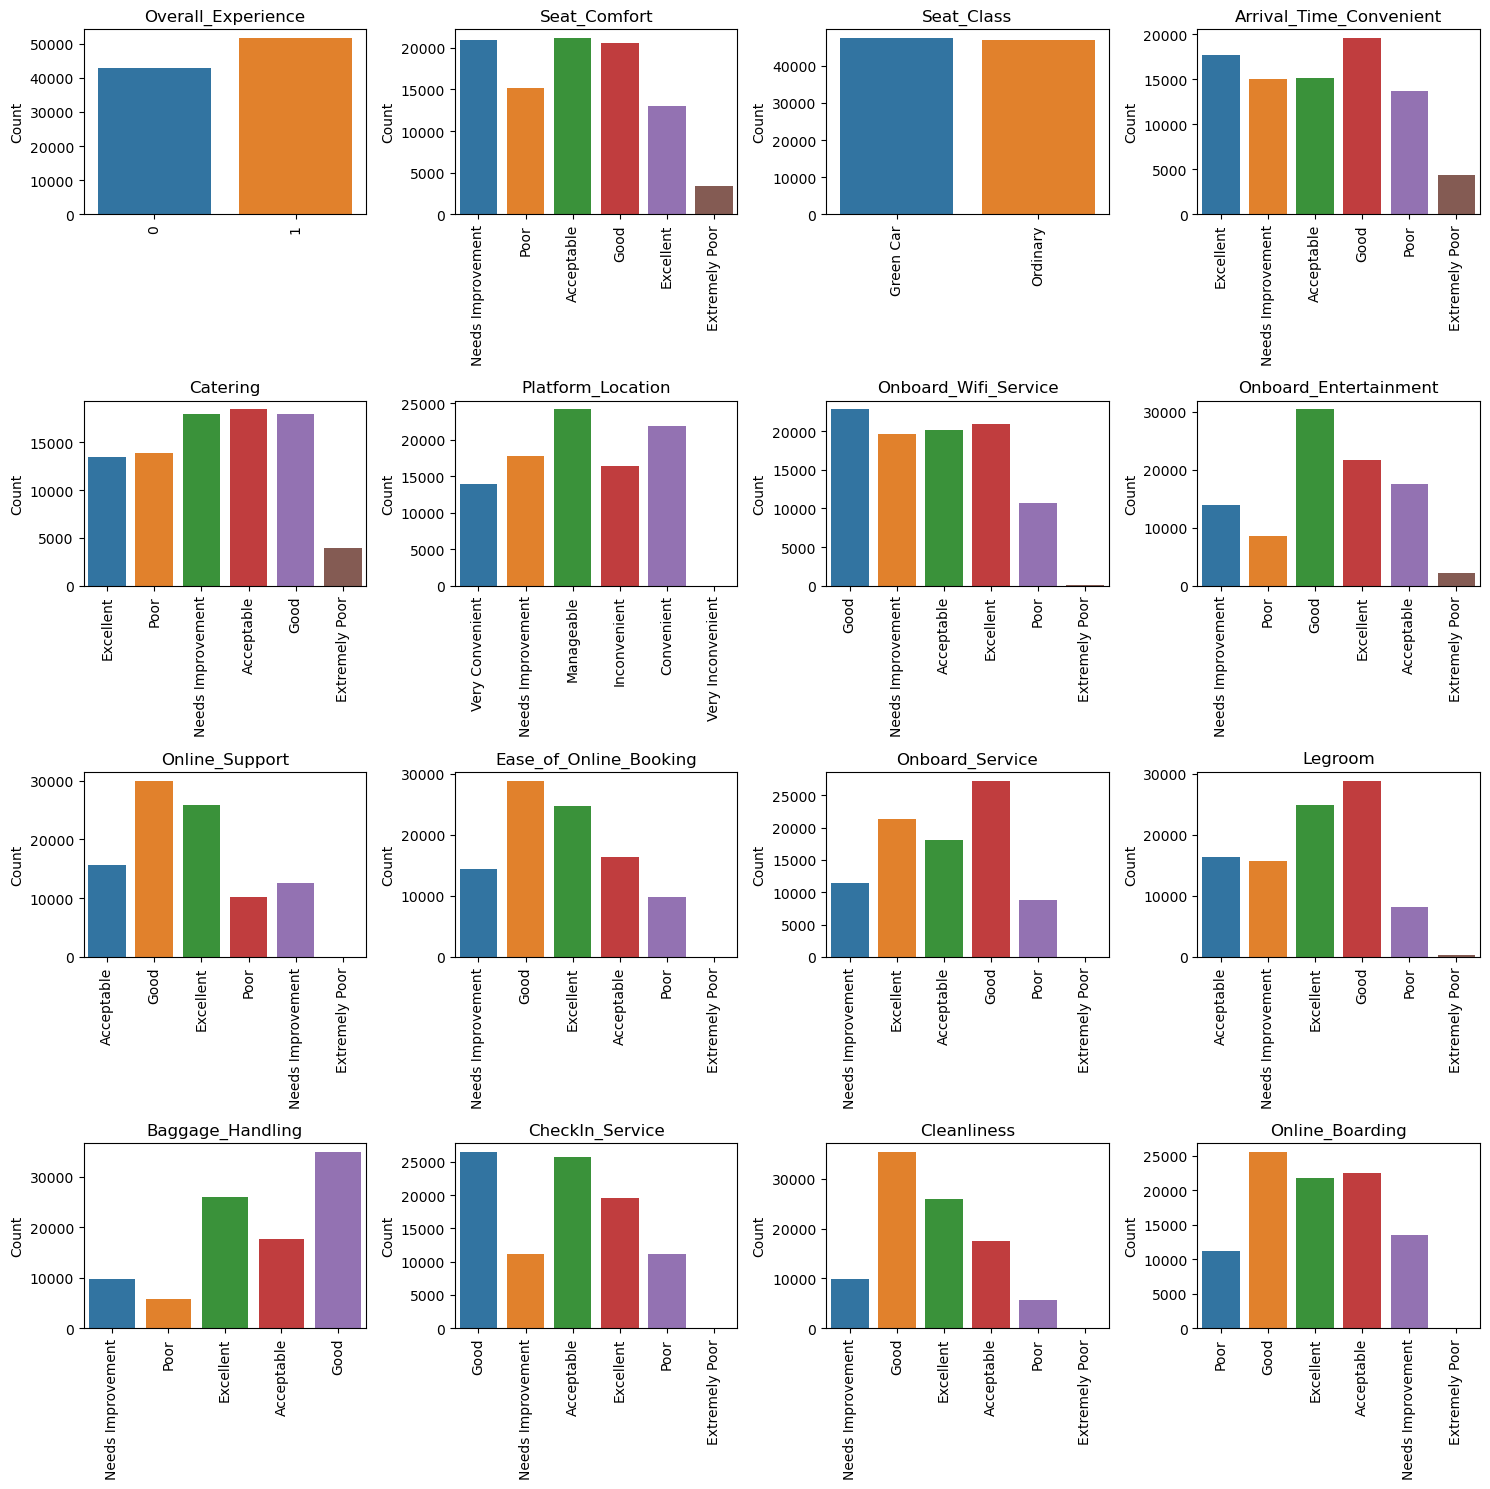

In [62]:
# Create a subset DataFrame containing only the categorical variables
categorical_cols = ['Overall_Experience', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient',
                    'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
                    'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
                    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']

categorical_cols_test = ['Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient',
                    'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment',
                    'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
                    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']

categorical_df = data[categorical_cols]

def plot_categorical_variables(data, categorical_cols):
    # Create a subset DataFrame containing only the categorical variables
    categorical_df = data[categorical_cols]

    # Set up the figure and axes for plotting
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each categorical column and create count plots
    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        sns.countplot(data=categorical_df, x=col, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=90)

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()
    
plot_categorical_variables(survey_data_train, categorical_cols)

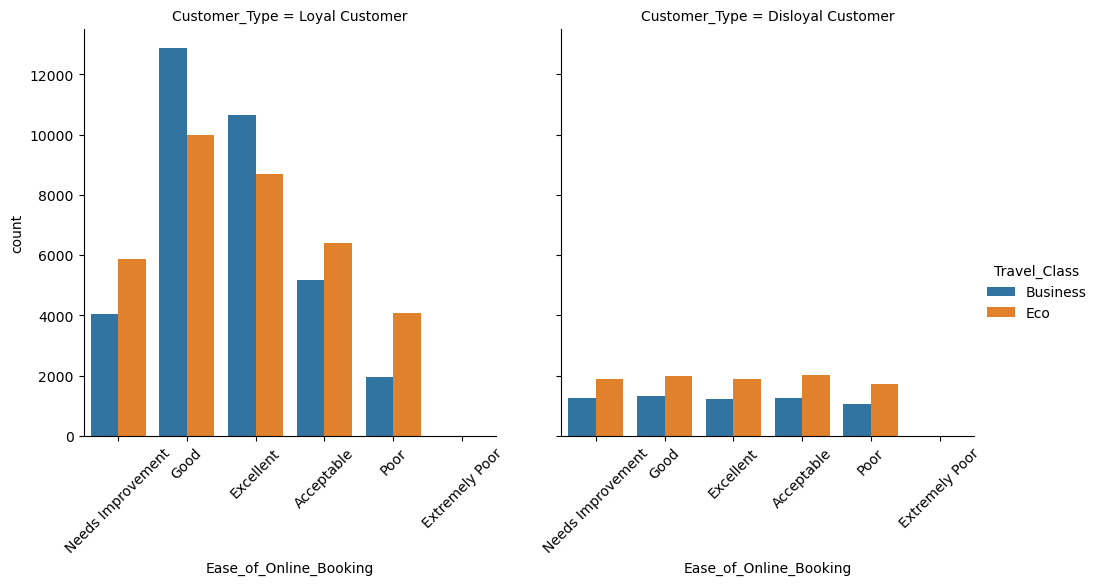

In [59]:
g=sns.catplot(x='Ease_of_Online_Booking', hue='Travel_Class', col='Customer_Type', kind='count', data=data)
g.set_xticklabels(rotation=45)
plt.show()

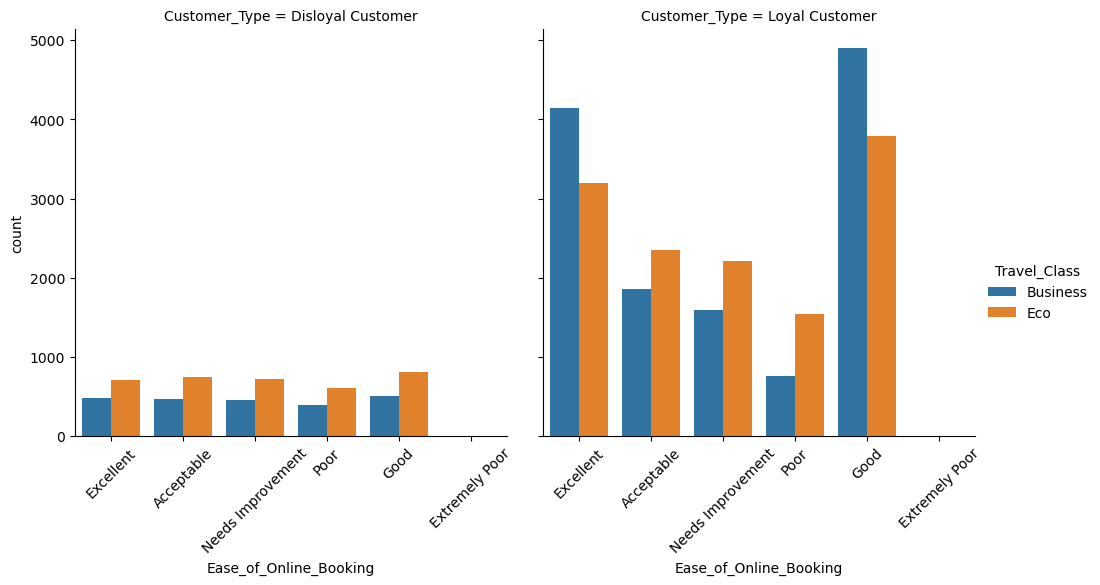

In [60]:
g=sns.catplot(x='Ease_of_Online_Booking', hue='Travel_Class', col='Customer_Type', kind='count', data=tdata)
g.set_xticklabels(rotation=45)
plt.show()

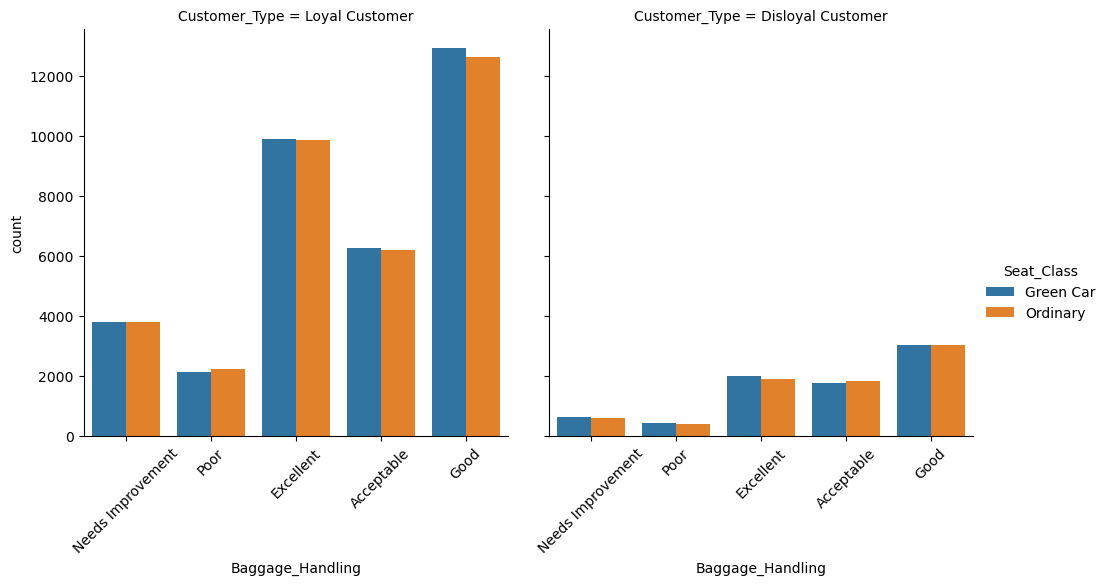

In [32]:
g = sns.catplot(x='Baggage_Handling', hue='Seat_Class', col='Customer_Type', kind='count', data=data)
g.set_xticklabels(rotation=45)
plt.show()

In [55]:
# data[(data['Platform_Location'] == "Inconvenient") & (data['Overall_Experience'] == "0")].T

data[(data['Platform_Location'] == "Inconvenient") & (data['Overall_Experience'] == 0)].T


,6,7,14,42,70,93,115,196,229,232,...,94318,94322,94325,94335,94339,94341,94343,94367,94371,94373
ID,98800007,98800008,98800015,98800043,98800071,98800094,98800116,98800197,98800230,98800233,...,98894319,98894323,98894326,98894336,98894340,98894342,98894344,98894368,98894372,98894374
Gender,Male,Male,Male,Male,Male,Female,Male,Male,Male,Male,...,Male,Male,Female,Female,Male,Male,Male,Male,Female,Male
Customer_Type,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Disloyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,NaN,...,Disloyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer,Loyal Customer
Age,56.0,65.0,33.0,25.0,55.0,30.0,22.0,9.0,35.0,29.0,...,25.0,63.0,62.0,65.0,29.0,57.0,50.0,14.0,58.0,57.0
Type_Travel,Personal Travel,Personal Travel,Business Travel,NaN,Business Travel,Business Travel,Business Travel,Personal Travel,Personal Travel,Personal Travel,...,Business Travel,Personal Travel,Business Travel,Business Travel,Business Travel,Personal Travel,Personal Travel,Personal Travel,Business Travel,Personal Travel
Travel_Class,Eco,Business,Business,Eco,Eco,Eco,Business,Eco,Eco,Eco,...,Eco,Eco,Business,Business,Business,Eco,Eco,Business,Business,Eco
Travel_Distance,2029,853,1180,1382,1554,1861,4733,1478,2074,1812,...,1806,1645,3433,3183,3304,2810,2306,2842,502,1534
Departure_Delay_in_Mins,0.0,0.0,49.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,21.0,60.0,35.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0
Arrival_Delay_in_Mins,0.0,3.0,49.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,23.0,58.0,30.0,0.0,0.0,0.0,0.0,141.0,30.0,0.0
Overall_Experience,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


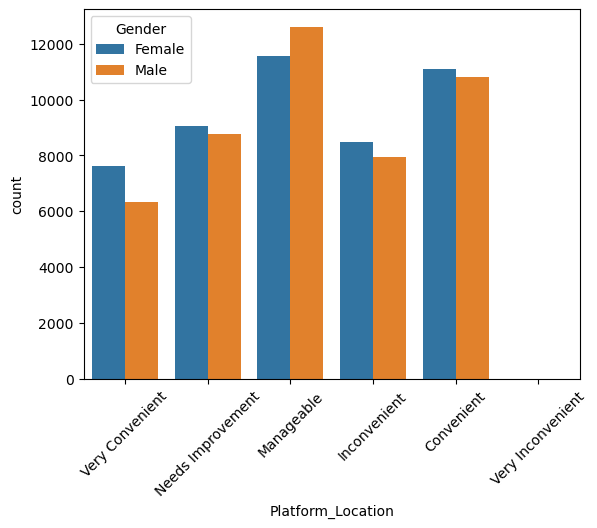

In [38]:
ax = sns.countplot(x='Platform_Location', hue='Gender', data=data)
plt.xticks(rotation=45)
plt.show()

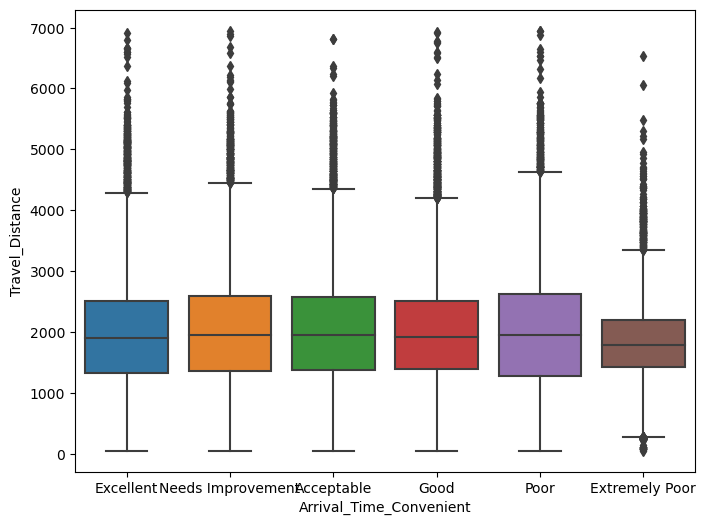

In [37]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Arrival_Time_Convenient', y='Travel_Distance', data=data)
plt.show()

In [ ]:
travel_data_train.isnull().sum().sort_values(ascending=False) 

In [ ]:
travel_data_train.dtypes

In [ ]:
survey_data_train = pd.read_csv("datasets/Surveydata_train_.csv")

In [ ]:
survey_data_train.dtypes

In [9]:
def prepare_travel_data(data):

    ## Set Customer to Loyal Customer if travelling in Business Class
    #data.loc[data['Customer_Type'].isnull(), 'Customer_Type'] = data.loc[data['Customer_Type'].isnull(), 'Travel_Class'].apply(
    #    lambda x: 'Business' if x == 'Loyal' else 'Disloyal Customer')

    # Fill missing values in 'Type_Travel' based on 'Travel_Class'
    data.loc[data['Type_Travel'].isnull(), 'Type_Travel'] = data.loc[data['Type_Travel'].isnull(), 'Travel_Class'].apply(
        lambda x: 'Business Travel' if x == 'Business' else 'Personal Travel')

    # Copy Departure delay into Arrival_delay
    data.loc[data['Arrival_Delay_in_Mins'].isnull(), 'Arrival_Delay_in_Mins'] = \
        data.loc[data['Arrival_Delay_in_Mins'].isnull(), 'Departure_Delay_in_Mins']

    # Replace with Median remaining NULL values
    data.loc[data['Arrival_Delay_in_Mins'].isnull(), 'Arrival_Delay_in_Mins'] = \
                            data['Arrival_Delay_in_Mins'].median()
    data.loc[data['Departure_Delay_in_Mins'].isnull(), 'Departure_Delay_in_Mins'] = \
                            data['Departure_Delay_in_Mins'].median()

    # Process Age. Less than 1% missing. Using Median
    # Age to int and fillin with a median
    data['Age'].fillna(data['Age'].median(), inplace=True)

    #Process Gender

    # Count the missing values in the Gender column
    missing_count = data['Gender'].isna().sum()

    # Calculate the number of missing values to be filled with each category
    if missing_count > 0:
        male_count = missing_count // 2
        female_count = missing_count - male_count

        # Fill missing values with Male and Female categories
        data['Gender'] = data['Gender'].fillna('Male', limit=male_count)
        data['Gender'] = data['Gender'].fillna('Female', limit=female_count)
        
    ## Change object call to int
    data['Customer_Type'] = data['Customer_Type'].map({'Disloyal Customer': 0, 'Loyal Customer': 1})
    data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
    data['Type_Travel'] = data['Type_Travel'].map({'Personal Travel': 0, 'Business Travel': 1})
    data['Travel_Class'] = data['Travel_Class'].map({'Eco': 0, 'Business': 1})
    
    # Iterative imputer to fill in Customer Type
    imp = IterativeImputer(max_iter=100, random_state=0)
    imp.set_output(transform="pandas")
    data = imp.fit_transform(data)    
    
    data['ID'] = data['ID'].astype('int')
    
    return data

In [10]:
preped_travel_data = prepare_travel_data(travel_data_train)

In [11]:
preped_travel_data

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,0.0,1.000000,52.0,1.0,1.0,272.0,0.0,5.0
1,98800002,1.0,1.000000,48.0,0.0,0.0,2200.0,9.0,0.0
2,98800003,0.0,1.000000,43.0,1.0,1.0,1061.0,77.0,119.0
3,98800004,0.0,1.000000,44.0,1.0,1.0,780.0,13.0,18.0
4,98800005,0.0,1.000000,50.0,1.0,1.0,1981.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
94374,98894375,1.0,1.000000,32.0,1.0,1.0,1357.0,83.0,125.0
94375,98894376,1.0,1.000000,44.0,1.0,1.0,592.0,5.0,11.0
94376,98894377,1.0,1.011109,63.0,1.0,1.0,2794.0,0.0,0.0
94377,98894378,1.0,1.000000,16.0,0.0,0.0,2744.0,0.0,0.0


In [12]:
preped_travel_data.isnull().sum().sort_values(ascending=False) 

ID                         0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
dtype: int64

In [13]:
preped_travel_data.dtypes

ID                           int32
Gender                     float64
Customer_Type              float64
Age                        float64
Type_Travel                float64
Travel_Class               float64
Travel_Distance            float64
Departure_Delay_in_Mins    float64
Arrival_Delay_in_Mins      float64
dtype: object

In [14]:
survey_data_train.isnull().sum().sort_values(ascending=False)

Arrival_Time_Convenient    8930
Catering                   8741
Onboard_Service            7601
Baggage_Handling            142
Online_Support               91
Legroom                      90
CheckIn_Service              77
Ease_of_Online_Booking       73
Seat_Comfort                 61
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Cleanliness                   6
Online_Boarding               6
Overall_Experience            0
Seat_Class                    0
ID                            0
dtype: int64

In [15]:
survey_data_train.dtypes

ID                          int64
Overall_Experience          int64
Seat_Comfort               object
Seat_Class                 object
Arrival_Time_Convenient    object
Catering                   object
Platform_Location          object
Onboard_Wifi_Service       object
Onboard_Entertainment      object
Online_Support             object
Ease_of_Online_Booking     object
Onboard_Service            object
Legroom                    object
Baggage_Handling           object
CheckIn_Service            object
Cleanliness                object
Online_Boarding            object
dtype: object

In [63]:
def prepare_survey_data(data):
    
    print(data.dtypes)
    
    if data['Seat_Class'].dtype == 'object':
        data['Seat_Class'] = data['Seat_Class'].map({'Ordinary': 0, 'Green Car': 1})
    
    survey_cols1 = ['Arrival_Time_Convenient', 'Seat_Comfort', 'Onboard_Wifi_Service', 'Onboard_Entertainment', \
                    'Online_Support', 'Ease_of_Online_Booking', 'Legroom', 'Catering', 'Onboard_Service', \
                    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']

    
    if data['Platform_Location'].dtype == 'object':
        data['Platform_Location'] = data['Platform_Location'] \
                                            .map({            
                                                'missing': 0, 
                                                'Very Inconvenient': 1, 
                                                'Inconvenient': 2, 
                                                'Needs Improvement': 3, 
                                                'Manageable': 4, 
                                                'Convenient': 5, 
                                                'Very Convenient': 6})

    data.loc[data['Platform_Location'].isna(), 'Platform_Location'] = 0

    surveyQ_dict = { 
        'missing': 0,
        'Extremely Poor': 1, 
        'Poor': 2, 
        'Needs Improvement': 3, 
        'Acceptable': 4, 
        'Good': 5, 
        'Excellent': 6}

    for col in survey_cols1:
        if data[col].dtype == 'object':
            data[col] = data[col].map(surveyQ_dict)
       
    imputation_sequence = [('Legroom', IterativeImputer(max_iter=250, random_state=42)),
                           ('Online_Boarding', IterativeImputer(max_iter=250, random_state=42)),
                           ('Type_Travel', IterativeImputer(max_iter=250, random_state=42)),
                           ('Customer_Type', IterativeImputer(max_iter=250, random_state=42)),
                           ('Online_Support', IterativeImputer(max_iter=250, random_state=42)),
                           ('Travel_Class', IterativeImputer(max_iter=250, random_state=42)),
                           ('Gender', IterativeImputer(max_iter=250, random_state=42)),
                           ('Ease_of_Online_Booking', IterativeImputer(max_iter=250, random_state=42)),
                           ('Seat_Comfort', IterativeImputer(max_iter=250, random_state=42)),
                           ('Onboard_Entertainment', IterativeImputer(max_iter=250, random_state=42))                         
                          
                          ]
    #imp = IterativeImputer(max_iter=1000, imputation_order='descending', random_state=42)
    imp = IterativeImputer( max_iter=500, random_state=42)
    imp.imputation_sequence_ = imputation_sequence
    imp.set_output(transform="pandas")
    data = imp.fit_transform(data)    
    
    data['ID'] = data['ID'].astype('int')
    return data

In [64]:
preped_survey_data = prepare_survey_data(survey_data_train)

ID                          int64
Overall_Experience          int64
Seat_Comfort               object
Seat_Class                 object
Arrival_Time_Convenient    object
Catering                   object
Platform_Location          object
Onboard_Wifi_Service       object
Onboard_Entertainment      object
Online_Support             object
Ease_of_Online_Booking     object
Onboard_Service            object
Legroom                    object
Baggage_Handling           object
CheckIn_Service            object
Cleanliness                object
Online_Boarding            object
dtype: object


In [18]:
preped_survey_data.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,3.0,1.0,6.0,6.000000,6.0,5.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,2.0
1,98800002,0.0,2.0,0.0,6.0,2.000000,3.0,5.0,2.0,5.0,5.0,6.0,3.0,2.0,3.0,5.0,5.0
2,98800003,1.0,3.0,1.0,3.0,3.000000,3.0,3.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
3,98800004,0.0,4.0,0.0,3.0,3.318202,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
4,98800005,1.0,4.0,0.0,4.0,4.000000,4.0,3.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [19]:
preped_survey_data.dtypes

ID                           int32
Overall_Experience         float64
Seat_Comfort               float64
Seat_Class                 float64
Arrival_Time_Convenient    float64
Catering                   float64
Platform_Location          float64
Onboard_Wifi_Service       float64
Onboard_Entertainment      float64
Online_Support             float64
Ease_of_Online_Booking     float64
Onboard_Service            float64
Legroom                    float64
Baggage_Handling           float64
CheckIn_Service            float64
Cleanliness                float64
Online_Boarding            float64
dtype: object

In [20]:
preped_survey_data.isna().sum().sort_values(ascending=False)

ID                         0
Online_Support             0
Cleanliness                0
CheckIn_Service            0
Baggage_Handling           0
Legroom                    0
Onboard_Service            0
Ease_of_Online_Booking     0
Onboard_Entertainment      0
Overall_Experience         0
Onboard_Wifi_Service       0
Platform_Location          0
Catering                   0
Arrival_Time_Convenient    0
Seat_Class                 0
Seat_Comfort               0
Online_Boarding            0
dtype: int64

In [21]:
data_in =  pd.merge(preped_travel_data, preped_survey_data, on='ID', how='inner')

# Drop ID. Coz we don't need it anymore.
#data_in.drop('ID', axis=1, inplace=True)

data_in.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.0,52.0,1.0,1.0,272.0,0.0,5.0,0.0,...,5.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,2.0
1,98800002,1.0,1.0,48.0,0.0,0.0,2200.0,9.0,0.0,0.0,...,5.0,2.0,5.0,5.0,6.0,3.0,2.0,3.0,5.0,5.0
2,98800003,0.0,1.0,43.0,1.0,1.0,1061.0,77.0,119.0,1.0,...,3.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
3,98800004,0.0,1.0,44.0,1.0,1.0,780.0,13.0,18.0,0.0,...,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
4,98800005,0.0,1.0,50.0,1.0,1.0,1981.0,0.0,0.0,1.0,...,3.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [22]:
data_in.dtypes

ID                           int32
Gender                     float64
Customer_Type              float64
Age                        float64
Type_Travel                float64
Travel_Class               float64
Travel_Distance            float64
Departure_Delay_in_Mins    float64
Arrival_Delay_in_Mins      float64
Overall_Experience         float64
Seat_Comfort               float64
Seat_Class                 float64
Arrival_Time_Convenient    float64
Catering                   float64
Platform_Location          float64
Onboard_Wifi_Service       float64
Onboard_Entertainment      float64
Online_Support             float64
Ease_of_Online_Booking     float64
Onboard_Service            float64
Legroom                    float64
Baggage_Handling           float64
CheckIn_Service            float64
Cleanliness                float64
Online_Boarding            float64
dtype: object

In [23]:
data_in

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0.0,1.000000,52.0,1.0,1.0,272.0,0.0,5.0,0.0,...,5.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,2.0
1,98800002,1.0,1.000000,48.0,0.0,0.0,2200.0,9.0,0.0,0.0,...,5.0,2.0,5.0,5.0,6.0,3.0,2.0,3.0,5.0,5.0
2,98800003,0.0,1.000000,43.0,1.0,1.0,1061.0,77.0,119.0,1.0,...,3.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0
3,98800004,0.0,1.000000,44.0,1.0,1.0,780.0,13.0,18.0,0.0,...,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0
4,98800005,0.0,1.000000,50.0,1.0,1.0,1981.0,0.0,0.0,1.0,...,3.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375,1.0,1.000000,32.0,1.0,1.0,1357.0,83.0,125.0,0.0,...,2.0,2.0,2.0,2.0,5.0,5.0,5.0,3.0,5.0,2.0
94375,98894376,1.0,1.000000,44.0,1.0,1.0,592.0,5.0,11.0,1.0,...,3.0,6.0,6.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
94376,98894377,1.0,1.011109,63.0,1.0,1.0,2794.0,0.0,0.0,1.0,...,5.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0
94377,98894378,1.0,1.000000,16.0,0.0,0.0,2744.0,0.0,0.0,0.0,...,5.0,3.0,5.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0


In [24]:

data_in_stats = data_in.describe(include='all').T
data_in_stats

,count,mean,std,min,25%,50%,75%,max
ID,94379.0,9.884719e+07,27245.014865,9.880000e+07,98823595.5,98847190.0,98870784.5,9.889438e+07
Gender,94379.0,4.929592e-01,0.499953,0.000000e+00,0.0,0.0,1.0,1.000000e+00
Customer_Type,94379.0,8.163233e-01,0.372331,0.000000e+00,1.0,1.0,1.0,1.428596e+00
Age,94379.0,3.941985e+01,15.113993,7.000000e+00,27.0,40.0,51.0,8.500000e+01
Type_Travel,94379.0,6.676697e-01,0.471051,0.000000e+00,0.0,1.0,1.0,1.000000e+00
Travel_Class,94379.0,4.771930e-01,0.499482,0.000000e+00,0.0,0.0,1.0,1.000000e+00
Travel_Distance,94379.0,1.978888e+03,1027.961019,5.000000e+01,1359.0,1923.0,2538.0,6.951000e+03
Departure_Delay_in_Mins,94379.0,1.463825e+01,38.128961,0.000000e+00,0.0,0.0,12.0,1.592000e+03
Arrival_Delay_in_Mins,94379.0,1.506850e+01,38.584584,0.000000e+00,0.0,0.0,13.0,1.584000e+03
Overall_Experience,94379.0,5.466576e-01,0.497821,0.000000e+00,0.0,1.0,1.0,1.000000e+00


In [25]:
data_in.to_csv('Hackathon_Train_IterImputer.csv', index=False)

In [26]:
## Read it back as a check
data_in = pd.read_csv('Hackathon_Train_IterImputer.csv')

In [27]:
data_in.isnull().sum().sort_values(ascending=False) 

ID                         0
Catering                   0
Cleanliness                0
CheckIn_Service            0
Baggage_Handling           0
Legroom                    0
Onboard_Service            0
Ease_of_Online_Booking     0
Online_Support             0
Onboard_Entertainment      0
Onboard_Wifi_Service       0
Platform_Location          0
Arrival_Time_Convenient    0
Gender                     0
Seat_Class                 0
Seat_Comfort               0
Overall_Experience         0
Arrival_Delay_in_Mins      0
Departure_Delay_in_Mins    0
Travel_Distance            0
Travel_Class               0
Type_Travel                0
Age                        0
Customer_Type              0
Online_Boarding            0
dtype: int64

In [28]:
data_in = data_in.drop('ID', axis=1)
X,y = data_in.drop(['Overall_Experience'],axis = 1) , data_in['Overall_Experience']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [29]:
X_test.head(10).T

,35221,12640,53656,1165,68981,49131,48541,28785,38642,92276
Gender,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.0,1.0,0.0,1.000000
Customer_Type,1.0,0.648306,1.000000,1.0,1.110337,1.0,1.0,1.0,1.0,1.000000
Age,59.0,17.000000,68.000000,39.0,59.000000,12.0,60.0,43.0,42.0,44.000000
Type_Travel,1.0,1.000000,1.000000,0.0,0.000000,0.0,1.0,1.0,1.0,0.000000
Travel_Class,1.0,1.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,0.000000
Travel_Distance,3715.0,1948.000000,408.000000,1793.0,2630.000000,2699.0,349.0,1878.0,2788.0,2093.000000
Departure_Delay_in_Mins,6.0,2.000000,0.000000,0.0,288.000000,0.0,8.0,51.0,0.0,13.000000
Arrival_Delay_in_Mins,3.0,0.000000,12.000000,0.0,279.000000,7.0,4.0,61.0,0.0,7.000000
Seat_Comfort,3.0,3.000000,3.000000,3.0,3.000000,3.0,5.0,3.0,3.0,5.000000
Seat_Class,0.0,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.000000


<a id="current">Current</a>

<a id="histboost">HistogramGradientBoosting</a>

### Model using HistGradientBoosting

Train AUC: 0.9615, Train Precison: 0.9699, Train Recall: 0.9591, Train F1 : 0.9645 

HistGradientBoosting Classifier - AUC: 0.99

HistGradientBoosting Classifier Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      8405
         1.0       0.97      0.95      0.96     10471

    accuracy                           0.96     18876
   macro avg       0.95      0.96      0.96     18876
weighted avg       0.96      0.96      0.96     18876

Best Threshold=0.001138, G-Mean=0.956


<Figure size 1200x600 with 0 Axes>

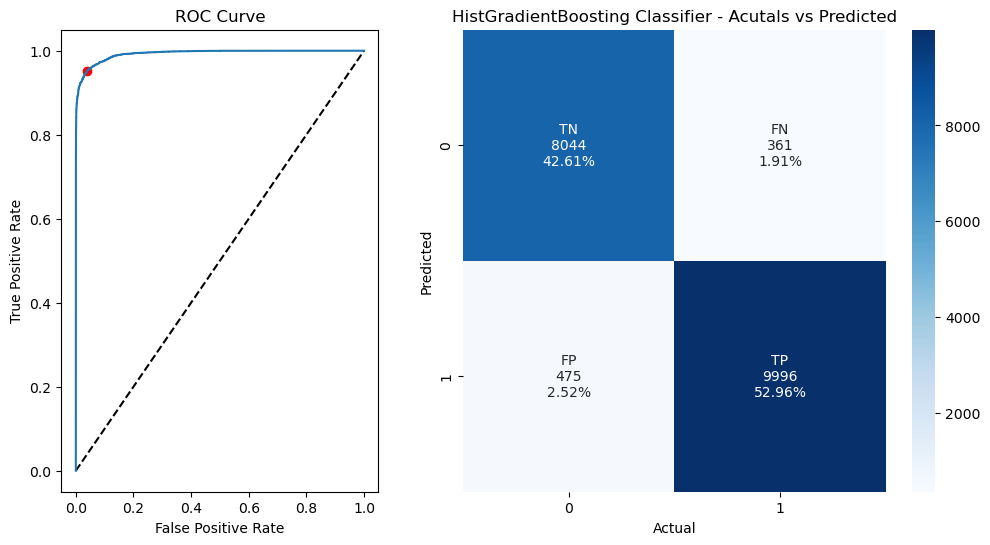

In [30]:
hgb_classifier = HistGradientBoostingClassifier(learning_rate=0.075, max_depth=10, max_iter=200, random_state=42)

# Fit the HistGradientBoostingClassifier moHistGradientBoostingClassifierdel to the selected features
hgb_classifier.fit(X_train, y_train)
# Make predictions on the test data

## Train scores
train_acc = hgb_classifier.score(X_train,y_train).round(4)
pred_train = hgb_classifier.predict(X_train).round(4)
y_scores_train = hgb_classifier.predict_proba(X_train).round(4)
train_recall = metrics.recall_score(y_train,pred_train).round(4)
train_precision = metrics.precision_score(y_train,pred_train).round(4)
train_f1 = metrics.f1_score(y_train,pred_train).round(4)

print(f"Train AUC: {train_acc}, Train Precison: {train_precision}, Train Recall: {train_recall}, Train F1 : {train_f1} \n")

predictions = hgb_classifier.predict(X_test)
y_scores = hgb_classifier.predict_proba(X_test)  # Score predictions
metrics_score2("HistGradientBoosting Classifier", y_test, predictions, y_scores)    # Print metrics

Train AUC: 0.999, Train Precison: 0.9996, Train Recall: 0.9986, Train F1 : 0.9991 

XGBoost Classifier - AUC: 0.99

XGBoost Classifier Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      8405
         1.0       0.97      0.95      0.96     10471

    accuracy                           0.96     18876
   macro avg       0.96      0.96      0.96     18876
weighted avg       0.96      0.96      0.96     18876

Best Threshold=0.000590, G-Mean=0.959


<Figure size 1200x600 with 0 Axes>

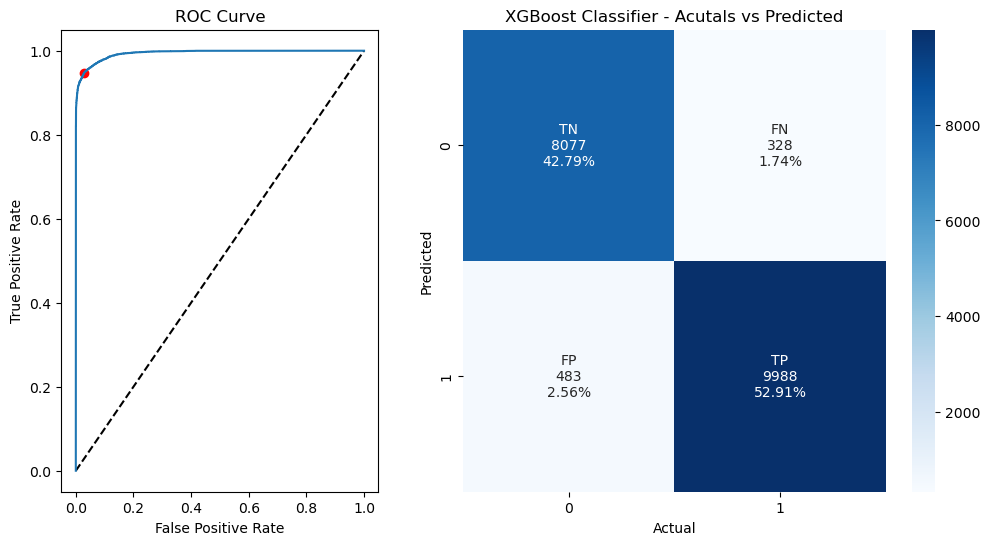

In [53]:
xgb_classifier = XGBClassifier(booster = 'gbtree', 
                               learning_rate = 0.075, max_depth= 15, min_child_weight= 3, n_estimators = 200, 
                               tree_method = 'approx')

# Fit the HistGradientBoostingClassifier moHistGradientBoostingClassifierdel to the selected features
xgb_classifier.fit(X_train, y_train)
# Make predictions on the test data

## Train scores
train_acc = xgb_classifier.score(X_train,y_train).round(4)
pred_train = xgb_classifier.predict(X_train).round(4)
y_scores_train = xgb_classifier.predict_proba(X_train).round(4)
train_recall = metrics.recall_score(y_train,pred_train).round(4)
train_precision = metrics.precision_score(y_train,pred_train).round(4)
train_f1 = metrics.f1_score(y_train,pred_train).round(4)

print(f"Train AUC: {train_acc}, Train Precison: {train_precision}, Train Recall: {train_recall}, Train F1 : {train_f1} \n")

predictions = xgb_classifier.predict(X_test)
y_scores = xgb_classifier.predict_proba(X_test)  # Score predictions
metrics_score2("XGBoost Classifier", y_test, predictions, y_scores)    # Print metrics

In [ ]:
xgb_classifier = XGBClassifier(booster = 'gbtree', 
                               learning_rate = 0.075, max_depth= 15, min_child_weight= 3, n_estimators = 200, 
                               tree_method = 'approx')

# Fit the HistGradientBoostingClassifier moHistGradientBoostingClassifierdel to the selected features
xgb_classifier.fit(X_train, y_train)
# Make predictions on the test data

## Train scores
train_acc = xgb_classifier.score(X_train,y_train).round(4)
pred_train = xgb_classifier.predict(X_train).round(4)
y_scores_train = xgb_classifier.predict_proba(X_train).round(4)
train_recall = metrics.recall_score(y_train,pred_train).round(4)
train_precision = metrics.precision_score(y_train,pred_train).round(4)
train_f1 = metrics.f1_score(y_train,pred_train).round(4)

print(f"Train AUC: {train_acc}, Train Precison: {train_precision}, Train Recall: {train_recall}, Train F1 : {train_f1} \n")

predictions = xgb_classifier.predict(X_test)
y_scores = xgb_classifier.predict_proba(X_test)  # Score predictions
metrics_score2("XGBoost Classifier", y_test, predictions, y_scores)    # Print metrics

In [91]:

from catboost import CatBoostClassifier

# Define the hyperparameters for the CatBoost algorithm
#params = {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'iterations': 500} # Almost there A1
params = {'learning_rate': 0.01, 'depth': 10, 'l2_leaf_reg': 3, 'iterations': 2000}

In [92]:
cat_classifier = CatBoostClassifier(**params)

# Fit the HistGradientBoostingClassifier moHistGradientBoostingClassifierdel to the selected features
cat_classifier.fit(X_train, y_train)
# Make predictions on the test data

## Train scores
train_acc = cat_classifier.score(X_train,y_train).round(4)
pred_train = cat_classifier.predict(X_train).round(4)
y_scores_train = cat_classifier.predict_proba(X_train).round(4)
train_recall = metrics.recall_score(y_train,pred_train).round(4)
train_precision = metrics.precision_score(y_train,pred_train).round(4)
train_f1 = metrics.f1_score(y_train,pred_train).round(4)

print(f"Train AUC: {train_acc}, Train Precison: {train_precision}, Train Recall: {train_recall}, Train F1 : {train_f1} \n")

predictions = cat_classifier.predict(X_test)
y_scores = cat_classifier.predict_proba(X_test)  # Score predictions


0:	learn: 0.6769332	total: 48.5ms	remaining: 1m 36s
1:	learn: 0.6615912	total: 89ms	remaining: 1m 28s
2:	learn: 0.6446329	total: 130ms	remaining: 1m 26s
3:	learn: 0.6301506	total: 171ms	remaining: 1m 25s
4:	learn: 0.6152576	total: 211ms	remaining: 1m 24s
5:	learn: 0.6020246	total: 251ms	remaining: 1m 23s
6:	learn: 0.5881377	total: 299ms	remaining: 1m 25s
7:	learn: 0.5737621	total: 342ms	remaining: 1m 25s
8:	learn: 0.5599447	total: 383ms	remaining: 1m 24s
9:	learn: 0.5485150	total: 424ms	remaining: 1m 24s
10:	learn: 0.5378298	total: 466ms	remaining: 1m 24s
11:	learn: 0.5270941	total: 506ms	remaining: 1m 23s
12:	learn: 0.5164857	total: 553ms	remaining: 1m 24s
13:	learn: 0.5065159	total: 597ms	remaining: 1m 24s
14:	learn: 0.4959977	total: 640ms	remaining: 1m 24s
15:	learn: 0.4869845	total: 689ms	remaining: 1m 25s
16:	learn: 0.4774490	total: 742ms	remaining: 1m 26s
17:	learn: 0.4682724	total: 792ms	remaining: 1m 27s
18:	learn: 0.4597076	total: 836ms	remaining: 1m 27s
19:	learn: 0.4505224	t

161:	learn: 0.1687887	total: 7.74s	remaining: 1m 27s
162:	learn: 0.1683206	total: 7.79s	remaining: 1m 27s
163:	learn: 0.1678179	total: 7.83s	remaining: 1m 27s
164:	learn: 0.1672901	total: 7.88s	remaining: 1m 27s
165:	learn: 0.1668519	total: 7.93s	remaining: 1m 27s
166:	learn: 0.1664758	total: 7.98s	remaining: 1m 27s
167:	learn: 0.1660326	total: 8.03s	remaining: 1m 27s
168:	learn: 0.1657033	total: 8.08s	remaining: 1m 27s
169:	learn: 0.1652429	total: 8.13s	remaining: 1m 27s
170:	learn: 0.1647408	total: 8.17s	remaining: 1m 27s
171:	learn: 0.1644061	total: 8.22s	remaining: 1m 27s
172:	learn: 0.1640102	total: 8.27s	remaining: 1m 27s
173:	learn: 0.1636384	total: 8.31s	remaining: 1m 27s
174:	learn: 0.1633083	total: 8.36s	remaining: 1m 27s
175:	learn: 0.1628095	total: 8.41s	remaining: 1m 27s
176:	learn: 0.1624255	total: 8.46s	remaining: 1m 27s
177:	learn: 0.1622089	total: 8.51s	remaining: 1m 27s
178:	learn: 0.1619246	total: 8.56s	remaining: 1m 27s
179:	learn: 0.1615704	total: 8.61s	remaining: 

319:	learn: 0.1286028	total: 14.8s	remaining: 1m 17s
320:	learn: 0.1284170	total: 14.9s	remaining: 1m 17s
321:	learn: 0.1282739	total: 14.9s	remaining: 1m 17s
322:	learn: 0.1281720	total: 15s	remaining: 1m 17s
323:	learn: 0.1280090	total: 15s	remaining: 1m 17s
324:	learn: 0.1278497	total: 15.1s	remaining: 1m 17s
325:	learn: 0.1276988	total: 15.1s	remaining: 1m 17s
326:	learn: 0.1276090	total: 15.2s	remaining: 1m 17s
327:	learn: 0.1274857	total: 15.2s	remaining: 1m 17s
328:	learn: 0.1273332	total: 15.3s	remaining: 1m 17s
329:	learn: 0.1271259	total: 15.4s	remaining: 1m 17s
330:	learn: 0.1269567	total: 15.4s	remaining: 1m 17s
331:	learn: 0.1268244	total: 15.5s	remaining: 1m 17s
332:	learn: 0.1267418	total: 15.5s	remaining: 1m 17s
333:	learn: 0.1266271	total: 15.6s	remaining: 1m 17s
334:	learn: 0.1264463	total: 15.6s	remaining: 1m 17s
335:	learn: 0.1263056	total: 15.7s	remaining: 1m 17s
336:	learn: 0.1261914	total: 15.8s	remaining: 1m 17s
337:	learn: 0.1260506	total: 15.8s	remaining: 1m 1

475:	learn: 0.1109845	total: 24.7s	remaining: 1m 19s
476:	learn: 0.1108406	total: 24.8s	remaining: 1m 19s
477:	learn: 0.1107713	total: 24.8s	remaining: 1m 19s
478:	learn: 0.1106726	total: 24.9s	remaining: 1m 19s
479:	learn: 0.1105610	total: 25s	remaining: 1m 19s
480:	learn: 0.1104765	total: 25s	remaining: 1m 19s
481:	learn: 0.1103892	total: 25.1s	remaining: 1m 19s
482:	learn: 0.1102510	total: 25.1s	remaining: 1m 18s
483:	learn: 0.1101367	total: 25.2s	remaining: 1m 18s
484:	learn: 0.1100470	total: 25.3s	remaining: 1m 18s
485:	learn: 0.1099964	total: 25.3s	remaining: 1m 18s
486:	learn: 0.1098974	total: 25.4s	remaining: 1m 18s
487:	learn: 0.1098134	total: 25.5s	remaining: 1m 18s
488:	learn: 0.1097489	total: 25.5s	remaining: 1m 18s
489:	learn: 0.1096631	total: 25.6s	remaining: 1m 18s
490:	learn: 0.1095735	total: 25.7s	remaining: 1m 18s
491:	learn: 0.1095070	total: 25.7s	remaining: 1m 18s
492:	learn: 0.1094030	total: 25.8s	remaining: 1m 18s
493:	learn: 0.1093074	total: 25.9s	remaining: 1m 1

631:	learn: 0.0993299	total: 34.5s	remaining: 1m 14s
632:	learn: 0.0992674	total: 34.5s	remaining: 1m 14s
633:	learn: 0.0991991	total: 34.6s	remaining: 1m 14s
634:	learn: 0.0991287	total: 34.7s	remaining: 1m 14s
635:	learn: 0.0990612	total: 34.7s	remaining: 1m 14s
636:	learn: 0.0989844	total: 34.8s	remaining: 1m 14s
637:	learn: 0.0989270	total: 34.8s	remaining: 1m 14s
638:	learn: 0.0988520	total: 34.9s	remaining: 1m 14s
639:	learn: 0.0987802	total: 34.9s	remaining: 1m 14s
640:	learn: 0.0986923	total: 35s	remaining: 1m 14s
641:	learn: 0.0986356	total: 35.1s	remaining: 1m 14s
642:	learn: 0.0985696	total: 35.1s	remaining: 1m 14s
643:	learn: 0.0984724	total: 35.2s	remaining: 1m 14s
644:	learn: 0.0984225	total: 35.2s	remaining: 1m 14s
645:	learn: 0.0983681	total: 35.3s	remaining: 1m 13s
646:	learn: 0.0983057	total: 35.3s	remaining: 1m 13s
647:	learn: 0.0982231	total: 35.4s	remaining: 1m 13s
648:	learn: 0.0981767	total: 35.5s	remaining: 1m 13s
649:	learn: 0.0981265	total: 35.5s	remaining: 1m

788:	learn: 0.0907088	total: 44.7s	remaining: 1m 8s
789:	learn: 0.0906667	total: 44.8s	remaining: 1m 8s
790:	learn: 0.0905866	total: 44.8s	remaining: 1m 8s
791:	learn: 0.0905479	total: 44.9s	remaining: 1m 8s
792:	learn: 0.0905273	total: 44.9s	remaining: 1m 8s
793:	learn: 0.0904737	total: 45s	remaining: 1m 8s
794:	learn: 0.0904377	total: 45.1s	remaining: 1m 8s
795:	learn: 0.0903838	total: 45.1s	remaining: 1m 8s
796:	learn: 0.0903497	total: 45.2s	remaining: 1m 8s
797:	learn: 0.0902911	total: 45.2s	remaining: 1m 8s
798:	learn: 0.0902555	total: 45.3s	remaining: 1m 8s
799:	learn: 0.0902120	total: 45.3s	remaining: 1m 8s
800:	learn: 0.0901487	total: 45.4s	remaining: 1m 7s
801:	learn: 0.0900932	total: 45.5s	remaining: 1m 7s
802:	learn: 0.0900613	total: 45.5s	remaining: 1m 7s
803:	learn: 0.0899951	total: 45.6s	remaining: 1m 7s
804:	learn: 0.0899316	total: 45.6s	remaining: 1m 7s
805:	learn: 0.0898846	total: 45.7s	remaining: 1m 7s
806:	learn: 0.0898622	total: 45.7s	remaining: 1m 7s
807:	learn: 0.

948:	learn: 0.0837112	total: 54.5s	remaining: 1m
949:	learn: 0.0836765	total: 54.6s	remaining: 1m
950:	learn: 0.0836326	total: 54.7s	remaining: 1m
951:	learn: 0.0835956	total: 54.7s	remaining: 1m
952:	learn: 0.0835630	total: 54.8s	remaining: 1m
953:	learn: 0.0835205	total: 54.9s	remaining: 1m
954:	learn: 0.0834742	total: 55s	remaining: 1m
955:	learn: 0.0834401	total: 55s	remaining: 1m
956:	learn: 0.0833931	total: 55.1s	remaining: 1m
957:	learn: 0.0833409	total: 55.2s	remaining: 60s
958:	learn: 0.0833170	total: 55.2s	remaining: 59.9s
959:	learn: 0.0832863	total: 55.3s	remaining: 59.9s
960:	learn: 0.0832607	total: 55.4s	remaining: 59.9s
961:	learn: 0.0832102	total: 55.4s	remaining: 59.8s
962:	learn: 0.0831779	total: 55.5s	remaining: 59.8s
963:	learn: 0.0831435	total: 55.6s	remaining: 59.7s
964:	learn: 0.0831021	total: 55.6s	remaining: 59.7s
965:	learn: 0.0830489	total: 55.7s	remaining: 59.6s
966:	learn: 0.0830260	total: 55.8s	remaining: 59.6s
967:	learn: 0.0829881	total: 55.8s	remaining:

1107:	learn: 0.0780557	total: 1m 4s	remaining: 52s
1108:	learn: 0.0780286	total: 1m 4s	remaining: 51.9s
1109:	learn: 0.0780071	total: 1m 4s	remaining: 51.8s
1110:	learn: 0.0779749	total: 1m 4s	remaining: 51.8s
1111:	learn: 0.0779412	total: 1m 4s	remaining: 51.7s
1112:	learn: 0.0779248	total: 1m 4s	remaining: 51.7s
1113:	learn: 0.0778799	total: 1m 4s	remaining: 51.6s
1114:	learn: 0.0778384	total: 1m 4s	remaining: 51.5s
1115:	learn: 0.0777813	total: 1m 5s	remaining: 51.5s
1116:	learn: 0.0777443	total: 1m 5s	remaining: 51.4s
1117:	learn: 0.0776863	total: 1m 5s	remaining: 51.4s
1118:	learn: 0.0776456	total: 1m 5s	remaining: 51.3s
1119:	learn: 0.0776123	total: 1m 5s	remaining: 51.3s
1120:	learn: 0.0775629	total: 1m 5s	remaining: 51.2s
1121:	learn: 0.0775403	total: 1m 5s	remaining: 51.1s
1122:	learn: 0.0774883	total: 1m 5s	remaining: 51.1s
1123:	learn: 0.0774585	total: 1m 5s	remaining: 51s
1124:	learn: 0.0774297	total: 1m 5s	remaining: 51s
1125:	learn: 0.0774064	total: 1m 5s	remaining: 50.9s

1262:	learn: 0.0736087	total: 1m 14s	remaining: 43.5s
1263:	learn: 0.0735585	total: 1m 14s	remaining: 43.5s
1264:	learn: 0.0735206	total: 1m 14s	remaining: 43.4s
1265:	learn: 0.0735087	total: 1m 14s	remaining: 43.4s
1266:	learn: 0.0734936	total: 1m 14s	remaining: 43.3s
1267:	learn: 0.0734694	total: 1m 14s	remaining: 43.3s
1268:	learn: 0.0734379	total: 1m 15s	remaining: 43.2s
1269:	learn: 0.0734061	total: 1m 15s	remaining: 43.2s
1270:	learn: 0.0733805	total: 1m 15s	remaining: 43.1s
1271:	learn: 0.0733696	total: 1m 15s	remaining: 43s
1272:	learn: 0.0733355	total: 1m 15s	remaining: 43s
1273:	learn: 0.0732961	total: 1m 15s	remaining: 42.9s
1274:	learn: 0.0732635	total: 1m 15s	remaining: 42.9s
1275:	learn: 0.0732424	total: 1m 15s	remaining: 42.8s
1276:	learn: 0.0732046	total: 1m 15s	remaining: 42.8s
1277:	learn: 0.0731800	total: 1m 15s	remaining: 42.7s
1278:	learn: 0.0731548	total: 1m 15s	remaining: 42.7s
1279:	learn: 0.0731266	total: 1m 15s	remaining: 42.6s
1280:	learn: 0.0731043	total: 1m

1418:	learn: 0.0694931	total: 1m 24s	remaining: 34.5s
1419:	learn: 0.0694595	total: 1m 24s	remaining: 34.4s
1420:	learn: 0.0694398	total: 1m 24s	remaining: 34.4s
1421:	learn: 0.0694173	total: 1m 24s	remaining: 34.3s
1422:	learn: 0.0693899	total: 1m 24s	remaining: 34.2s
1423:	learn: 0.0693712	total: 1m 24s	remaining: 34.2s
1424:	learn: 0.0693432	total: 1m 24s	remaining: 34.1s
1425:	learn: 0.0693129	total: 1m 24s	remaining: 34.1s
1426:	learn: 0.0692880	total: 1m 24s	remaining: 34s
1427:	learn: 0.0692382	total: 1m 24s	remaining: 34s
1428:	learn: 0.0692046	total: 1m 24s	remaining: 33.9s
1429:	learn: 0.0691907	total: 1m 24s	remaining: 33.8s
1430:	learn: 0.0691699	total: 1m 24s	remaining: 33.8s
1431:	learn: 0.0691443	total: 1m 25s	remaining: 33.7s
1432:	learn: 0.0691298	total: 1m 25s	remaining: 33.7s
1433:	learn: 0.0691106	total: 1m 25s	remaining: 33.6s
1434:	learn: 0.0690792	total: 1m 25s	remaining: 33.6s
1435:	learn: 0.0690678	total: 1m 25s	remaining: 33.5s
1436:	learn: 0.0690560	total: 1m

1574:	learn: 0.0660243	total: 1m 34s	remaining: 25.4s
1575:	learn: 0.0660008	total: 1m 34s	remaining: 25.4s
1576:	learn: 0.0659864	total: 1m 34s	remaining: 25.3s
1577:	learn: 0.0659596	total: 1m 34s	remaining: 25.3s
1578:	learn: 0.0659502	total: 1m 34s	remaining: 25.2s
1579:	learn: 0.0659332	total: 1m 34s	remaining: 25.1s
1580:	learn: 0.0659118	total: 1m 34s	remaining: 25.1s
1581:	learn: 0.0659026	total: 1m 34s	remaining: 25s
1582:	learn: 0.0658758	total: 1m 34s	remaining: 25s
1583:	learn: 0.0658603	total: 1m 34s	remaining: 24.9s
1584:	learn: 0.0658403	total: 1m 34s	remaining: 24.8s
1585:	learn: 0.0658208	total: 1m 34s	remaining: 24.8s
1586:	learn: 0.0658029	total: 1m 34s	remaining: 24.7s
1587:	learn: 0.0657758	total: 1m 35s	remaining: 24.7s
1588:	learn: 0.0657592	total: 1m 35s	remaining: 24.6s
1589:	learn: 0.0657381	total: 1m 35s	remaining: 24.5s
1590:	learn: 0.0657183	total: 1m 35s	remaining: 24.5s
1591:	learn: 0.0656954	total: 1m 35s	remaining: 24.4s
1592:	learn: 0.0656748	total: 1m

1727:	learn: 0.0630188	total: 1m 43s	remaining: 16.3s
1728:	learn: 0.0629904	total: 1m 43s	remaining: 16.3s
1729:	learn: 0.0629820	total: 1m 43s	remaining: 16.2s
1730:	learn: 0.0629689	total: 1m 43s	remaining: 16.1s
1731:	learn: 0.0629555	total: 1m 43s	remaining: 16.1s
1732:	learn: 0.0629345	total: 1m 44s	remaining: 16s
1733:	learn: 0.0629228	total: 1m 44s	remaining: 16s
1734:	learn: 0.0628882	total: 1m 44s	remaining: 15.9s
1735:	learn: 0.0628664	total: 1m 44s	remaining: 15.8s
1736:	learn: 0.0628603	total: 1m 44s	remaining: 15.8s
1737:	learn: 0.0628443	total: 1m 44s	remaining: 15.7s
1738:	learn: 0.0628285	total: 1m 44s	remaining: 15.7s
1739:	learn: 0.0628150	total: 1m 44s	remaining: 15.6s
1740:	learn: 0.0628049	total: 1m 44s	remaining: 15.6s
1741:	learn: 0.0627838	total: 1m 44s	remaining: 15.5s
1742:	learn: 0.0627601	total: 1m 44s	remaining: 15.4s
1743:	learn: 0.0627427	total: 1m 44s	remaining: 15.4s
1744:	learn: 0.0627371	total: 1m 44s	remaining: 15.3s
1745:	learn: 0.0627262	total: 1m

1883:	learn: 0.0604781	total: 1m 53s	remaining: 6.97s
1884:	learn: 0.0604706	total: 1m 53s	remaining: 6.91s
1885:	learn: 0.0604652	total: 1m 53s	remaining: 6.85s
1886:	learn: 0.0604576	total: 1m 53s	remaining: 6.79s
1887:	learn: 0.0604413	total: 1m 53s	remaining: 6.73s
1888:	learn: 0.0604265	total: 1m 53s	remaining: 6.67s
1889:	learn: 0.0604009	total: 1m 53s	remaining: 6.61s
1890:	learn: 0.0603890	total: 1m 53s	remaining: 6.55s
1891:	learn: 0.0603748	total: 1m 53s	remaining: 6.49s
1892:	learn: 0.0603498	total: 1m 53s	remaining: 6.43s
1893:	learn: 0.0603286	total: 1m 53s	remaining: 6.37s
1894:	learn: 0.0603206	total: 1m 53s	remaining: 6.31s
1895:	learn: 0.0603139	total: 1m 53s	remaining: 6.25s
1896:	learn: 0.0602950	total: 1m 54s	remaining: 6.19s
1897:	learn: 0.0602848	total: 1m 54s	remaining: 6.13s
1898:	learn: 0.0602616	total: 1m 54s	remaining: 6.07s
1899:	learn: 0.0602460	total: 1m 54s	remaining: 6.01s
1900:	learn: 0.0602388	total: 1m 54s	remaining: 5.95s
1901:	learn: 0.0602242	total

catoost Classifier - AUC: 0.99

catoost Classifier Classification Report
----------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      8405
         1.0       0.97      0.96      0.96     10471

    accuracy                           0.96     18876
   macro avg       0.96      0.96      0.96     18876
weighted avg       0.96      0.96      0.96     18876

Best Threshold=0.000053, G-Mean=0.961


<Figure size 1200x600 with 0 Axes>

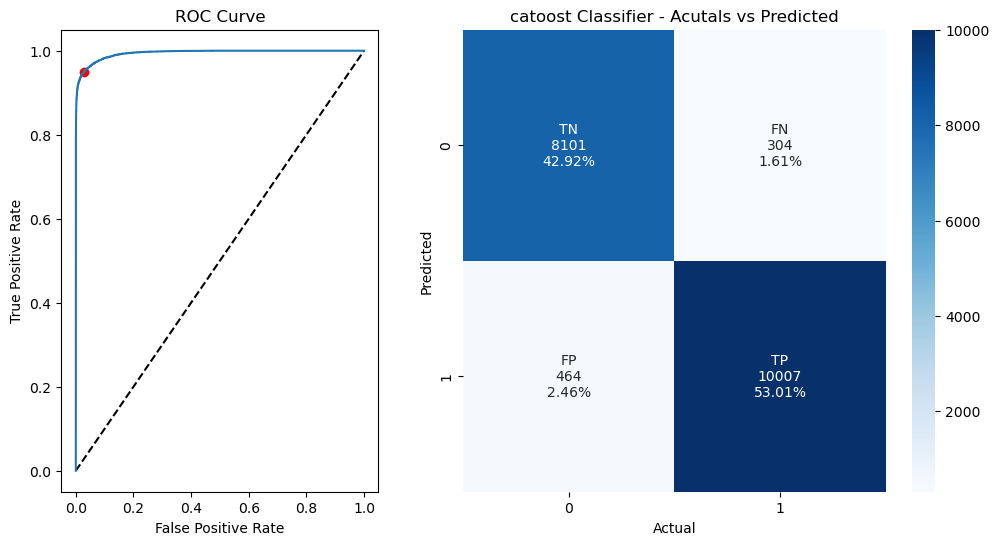

In [85]:
metrics_score2("catoost Classifier", y_test, predictions, y_scores)    # Print metrics

<a id="dataprep"></a>

## Data preparation

In [86]:
travel_data_test = pd.read_csv("datasets/TravelData_test_.csv")
survey_data_test = pd.read_csv("datasets/Surveydata_test_.csv")

preped_travel_test_data = prepare_travel_data(travel_data_test)
preped_survey_test_data = prepare_survey_data(survey_data_test)


ID                          int64
Seat_Comfort               object
Seat_Class                 object
Arrival_Time_Convenient    object
Catering                   object
Platform_Location          object
Onboard_Wifi_Service       object
Onboard_Entertainment      object
Online_Support             object
Ease_of_Online_Booking     object
Onboard_Service            object
Legroom                    object
Baggage_Handling           object
CheckIn_Service            object
Cleanliness                object
Online_Boarding            object
dtype: object


In [87]:
test_data =  pd.merge(preped_travel_test_data, preped_survey_test_data, on='ID', how='inner')
test_data.to_csv('Hackathon_Test_IterImputer.csv', index=False)

In [88]:
test_data.isnull().sum().sort_values(ascending=False) 

ID                         0
Gender                     0
Cleanliness                0
CheckIn_Service            0
Baggage_Handling           0
Legroom                    0
Onboard_Service            0
Ease_of_Online_Booking     0
Online_Support             0
Onboard_Entertainment      0
Onboard_Wifi_Service       0
Platform_Location          0
Catering                   0
Arrival_Time_Convenient    0
Seat_Class                 0
Seat_Comfort               0
Arrival_Delay_in_Mins      0
Departure_Delay_in_Mins    0
Travel_Distance            0
Travel_Class               0
Type_Travel                0
Age                        0
Customer_Type              0
Online_Boarding            0
dtype: int64

In [89]:
test_data = pd.read_csv('Hackathon_Test_IterImputer.csv')

submission = test_data['ID'].copy().to_frame()
test_data = test_data.drop('ID', axis = 1)

predictions = cat_classifier.predict(test_data)
submission['Overall_Experience']=predictions

In [90]:
submission.to_csv('submission.csv', index=False)

In [79]:
submission.shape

(35602, 2)

In [45]:
test_data = pd.read_csv('s.csv')

submission = test_data['ID'].copy().to_frame()
test_data = test_data.drop('ID', axis = 1)

predictions = xgb_classifier.predict(test_data)
submission['Overall_Experience']=predictions

In [ ]:
submission.shape

# The End